In [1]:
# Libraries
import pandas as pd
from pandas import DataFrame
from nltk import edit_distance
from fuzzywuzzy import fuzz
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
import numpy as np

In [2]:
from nltk.corpus import stopwords

In [3]:
# Get data
# df = pd.read_csv("cust10k.csv", delimiter="|")
file = "./affiliationstrings/affiliationstrings_ids.csv"
df = pd.read_csv(file, index_col=0)
df.columns=["entityname"]

In [4]:
df.head()

,entityname
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [5]:
df.loc[8544]

entityname    Department of Computer Engineering, Kyungpook ...
Name: 8544, dtype: object

In [6]:
df.shape

(2260, 1)

In [7]:
df.columns = ["entityname_original"]

In [8]:
df.head()

,entityname_original
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [9]:
# Stopword removal and lowercase conversion
# stop = stopwords.words("english")
# df["entityname"] = df["entityname_original"].apply(lambda x: " ".join(word for word in x.lower().split(" ") if word not in stop))
df["entityname"] = df["entityname_original"]

In [10]:
df.sample(5)

,entityname_original,entityname
id1,,
7279,"Computer Science Division, UC Berkeley","Computer Science Division, UC Berkeley"
2302,"Thomas J. Watson Research Center, IBM Research...","Thomas J. Watson Research Center, IBM Research..."
9373,"Boston University, Boston, USA","Boston University, Boston, USA"
8359,"University of California, USA","University of California, USA"
2240,AT&T Labs Inc.,AT&T Labs Inc.


In [11]:
# Main parameters
NUM_GROUPS = 20
THRESHOLD = 90

In [12]:
# Define number of groups and base of column names for results
grouplist = [f"Group{i}" for i in list(range(1, NUM_GROUPS+1))]
print(grouplist)

['Group1', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7', 'Group8', 'Group9', 'Group10', 'Group11', 'Group12', 'Group13', 'Group14', 'Group15', 'Group16', 'Group17', 'Group18', 'Group19', 'Group20']


In [13]:
def setup(grouplist):
    for g in grouplist:
        df[g] = None
        df[f"{g}_id1"] = None
        df[f"{g}_score"] = None

In [14]:
setup(grouplist) # RUN THIS FIRST!!!

In [15]:
df.head()

,entityname_original,entityname,Group1,Group1_id1,Group1_score,Group2,Group2_id1,Group2_score,Group3,Group3_id1,...,Group17_score,Group18,Group18_id1,Group18_score,Group19,Group19_id1,Group19_score,Group20,Group20_id1,Group20_score
id1,,,,,,,,,,,,,,,,,,,,,
7927,", IBM Almaden Research Center, 650 Harry Road,...",", IBM Almaden Research Center, 650 Harry Road,...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7930,", IIT Bombay",", IIT Bombay",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7987,", University of California, San Diego, USA",", University of California, San Diego, USA",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5613,"28msec Inc., Zurich, Switzerland","28msec Inc., Zurich, Switzerland",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9530,"28msec, Inc.","28msec, Inc.",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [16]:
# Run initial matching algorithm. Results will be fed to network graph later in order
# to extract additional matches using connected components.
for g in grouplist:
    print(f"Starting: {g}")
    print("=" * 72)
    initial = datetime.now()
    df = df.sample(frac=1)
    # indices of names for looping
    list_idx = [idx for idx in df.index]
    
    # Loop through names
#     num_records = 100 # restrict for debug
#     for idx in list_idx[:num_records]: # restrict for debug
    
    for idx in list_idx:
#         print("-" * 72)
        current_name = df.loc[idx]['entityname']
#         print(f"idx:{idx} name to compare: {current_name}")
        
    
        if df.loc[idx][g] is None:
            idx_to_compare = list_idx[list_idx.index(idx)+1:]
            for i in idx_to_compare:
                if df.loc[i][g] is None:
                    compare_name = df.loc[i]["entityname"]
                    fuzz_ratio = fuzz.ratio(current_name, compare_name)
                    fuzz_partial = fuzz.partial_ratio(current_name, compare_name)
                    fuzz_tokensort = fuzz.token_sort_ratio(current_name, compare_name)
                    similarity_score = max(fuzz_ratio, fuzz_partial, fuzz_tokensort) # Max of 3 different ratios
                    if similarity_score >= THRESHOLD:
    #                     print(f"Similarity score:{similarity_score}")
                        df.loc[df.index == i, g] = current_name
                        df.loc[df.index == i, f"{g}_score"] = similarity_score
                        df.loc[df.index == i, f"{g}_id1"] = idx
#         else:
#             print(f"{current_name} already matched. Skipping.")
    
    final = datetime.now()
    total_time = final - initial
    print("=" * 72)
    print(f"Group {g} total time: {total_time}")

print("Saving groups...")
df.to_csv("edit_dist_dedup_groups.csv")
print("Save complete!")

Starting: Group1
Group Group1 total time: 0:06:10.889446
Starting: Group2
Group Group2 total time: 0:06:14.820107
Starting: Group3
Group Group3 total time: 0:06:03.305454
Starting: Group4
Group Group4 total time: 0:06:10.289399
Starting: Group5
Group Group5 total time: 0:06:10.217126
Starting: Group6
Group Group6 total time: 0:06:27.981806
Starting: Group7
Group Group7 total time: 0:06:17.746774
Starting: Group8
Group Group8 total time: 0:05:47.942177
Starting: Group9
Group Group9 total time: 0:06:15.720412
Starting: Group10
Group Group10 total time: 0:06:07.354962
Starting: Group11
Group Group11 total time: 0:05:58.908112
Starting: Group12
Group Group12 total time: 0:06:00.407739
Starting: Group13
Group Group13 total time: 0:06:01.439707
Starting: Group14
Group Group14 total time: 0:06:24.995700
Starting: Group15
Group Group15 total time: 0:05:47.391391
Starting: Group16
Group Group16 total time: 0:06:02.617573
Starting: Group17
Group Group17 total time: 0:06:14.290600
Starting: Group

In [17]:
df.sample(5)

,entityname_original,entityname,Group1,Group1_id1,Group1_score,Group2,Group2_id1,Group2_score,Group3,Group3_id1,...,Group17_score,Group18,Group18_id1,Group18_score,Group19,Group19_id1,Group19_score,Group20,Group20_id1,Group20_score
id1,,,,,,,,,,,,,,,,,,,,,
6333,"UCLA, Los Angeles, CA, USA","UCLA, Los Angeles, CA, USA","UCLA, Los Angeles, CA",5394,100,None,None,None,"UCLA, Los Angeles, CA",5394,...,100,None,None,None,None,None,None,None,None,None
9792,"Carnegie Mellon University, 5000 Forbes Ave., ...","Carnegie Mellon University, 5000 Forbes Ave., ...","School of Computer Science, Carnegie Mellon Un...",7670,90,None,None,None,None,None,...,90,None,None,None,"School of Computer Science, Carnegie Mellon Un...",7670,90,"School of Computer Science, Carnegie Mellon Un...",7670,90
8649,"Technische Universität Dresden, Dresden, Germa...","Technische Universität Dresden, Dresden, Germa...",None,None,None,"Technische Universität Dresden, Dresden, Germany",679,100,"Technische Universität Dresden, Dresden, Germany",679,...,100,None,None,None,None,None,None,None,None,None
6509,"Institute of Computer Science, Forth, P.O, Box...","Institute of Computer Science, Forth, P.O, Box...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5574,"IBM Almaden, San Jose, CA, USA","IBM Almaden, San Jose, CA, USA",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [18]:
# group = grouplist[0]
# print(f"Number of matches: {df[group].value_counts().sum()}")
# print(f"Number of groups: {len(df[group].unique())}")
# df[group].value_counts()[:10]

In [19]:
# df.loc[df["entityname"].str.contains("AT&T")].head()

Remove duplicate permutations of tuples:

https://stackoverflow.com/questions/15352995/removing-permutations-from-a-list-of-tuples

In [20]:
matches_temp = []
for g in grouplist:
    matches_temp += list(zip(df[f"{g}_id1"].index, df[f"{g}_id1"].values))
matches_temp = list(set(matches_temp))

matches = []
for m in matches_temp:
    if m[0] is not None and m[1] is not None:
        matches.append(m)

# Remove permutation duplicates
matches = list(set(tuple(sorted(t)) for t in matches))

In [21]:
# REPLACED BY CODE ABOVE - DELETE IF ABOVE CODE WORKING
# matches_temp = list(set(list(zip(df["GroupA_id1"].index, df["GroupA_id1"].values)) + \
#         list(zip(df["GroupB_id1"].index, df["GroupB_id1"].values)) + \
#         list(zip(df["GroupC_id1"].index, df["GroupC_id1"].values)) + \
#         list(zip(df["GroupD_id1"].index, df["GroupD_id1"].values)) + \
#         list(zip(df["GroupE_id1"].index, df["GroupE_id1"].values)) + \
#         list(zip(df["GroupF_id1"].index, df["GroupF_id1"].values)) + \
#         list(zip(df["GroupG_id1"].index, df["GroupG_id1"].values)) + \
#         list(zip(df["GroupH_id1"].index, df["GroupH_id1"].values)) + \
#         list(zip(df["GroupI_id1"].index, df["GroupI_id1"].values)) + \
#         list(zip(df["GroupJ_id1"].index, df["GroupJ_id1"].values))))

# matches = []
# for m in matches_temp:
#     if m[0] is not None and m[1] is not None:
#         matches.append(m)

# # Remove permutation duplicates
# matches = list(set(tuple(sorted(t)) for t in matches))

In [22]:
len(matches)

5962

In [23]:
matches[:10]

[(3460, 6963),
 (3265, 9562),
 (2551, 5771),
 (3842, 9044),
 (6150, 6549),
 (4208, 9532),
 (7867, 8584),
 (3826, 5566),
 (1837, 2065),
 (679, 5136)]

In [24]:
df_matches = pd.DataFrame(matches)
df_matches.columns = ["entityid1", "entityid2"]
# df_matches.set_index("entityid1", inplace=True)
df_matches["match_string"] = df_matches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_matches.head()

,entityid1,entityid2,match_string
0,3460,6963,3460|6963
1,3265,9562,3265|9562
2,2551,5771,2551|5771
3,3842,9044,3842|9044
4,6150,6549,6150|6549


In [25]:
# Get ground truth
file = "./affiliationstrings/affiliationstrings_mapping.csv"
df_truth = pd.read_csv(file, index_col=0, header=None, names=["entityid1", "entityid2"])

In [26]:
truth_tuples = list(df_truth.reset_index().to_records(index=False))
truth_unique = list(set(tuple(sorted(t)) for t in truth_tuples))
truth_unique[:10]

[(3460, 6963),
 (1808, 4095),
 (3265, 9562),
 (2551, 5771),
 (6605, 7876),
 (3842, 9044),
 (6150, 6549),
 (4208, 9532),
 (9136, 9376),
 (2927, 8872)]

In [27]:
len(truth_unique)

16408

In [28]:
df_truthunique = pd.DataFrame(truth_unique)
df_truthunique.columns = ["entityid1", "entityid2"]
# df_truthunique.set_index("entityid1", inplace=True)
df_truthunique["match_string"] = df_truthunique.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_truthunique.head()

,entityid1,entityid2,match_string
0,3460,6963,3460|6963
1,1808,4095,1808|4095
2,3265,9562,3265|9562
3,2551,5771,2551|5771
4,6605,7876,6605|7876


In [29]:
matches_list = list(df_matches["match_string"])
truth_list = list(df_truthunique["match_string"])

In [30]:
len(matches_list)

5962

In [31]:
good_matches = []
for m in matches_list:
    if m in truth_list:
        good_matches.append("Good match")
    else:
        good_matches.append("Bad match")

In [32]:
len(good_matches)

5962

In [33]:
df_matches["GoodBad"] = good_matches

In [34]:
df_matches.head()

,entityid1,entityid2,match_string,GoodBad
0,3460,6963,3460|6963,Good match
1,3265,9562,3265|9562,Good match
2,2551,5771,2551|5771,Good match
3,3842,9044,3842|9044,Good match
4,6150,6549,6150|6549,Good match


In [35]:
df_matches["GoodBad"].value_counts()

Good match    4799
Bad match     1163
Name: GoodBad, dtype: int64

In [36]:
found_truth = []
for m in truth_list:
    if m in matches_list:
        found_truth.append("Found")
    else:
        found_truth.append("Not found")

In [37]:
len(found_truth)

16408

In [38]:
df_truthunique["Found"] = found_truth

In [39]:
df_truthunique.head()

,entityid1,entityid2,match_string,Found
0,3460,6963,3460|6963,Found
1,1808,4095,1808|4095,Not found
2,3265,9562,3265|9562,Found
3,2551,5771,2551|5771,Found
4,6605,7876,6605|7876,Not found


In [40]:
df_truthunique["Found"].value_counts()

Not found    11609
Found         4799
Name: Found, dtype: int64

### Use NetworkX to generate connected components

In [41]:
import networkx as nx

In [42]:
G = nx.Graph()
G.add_edges_from(matches)

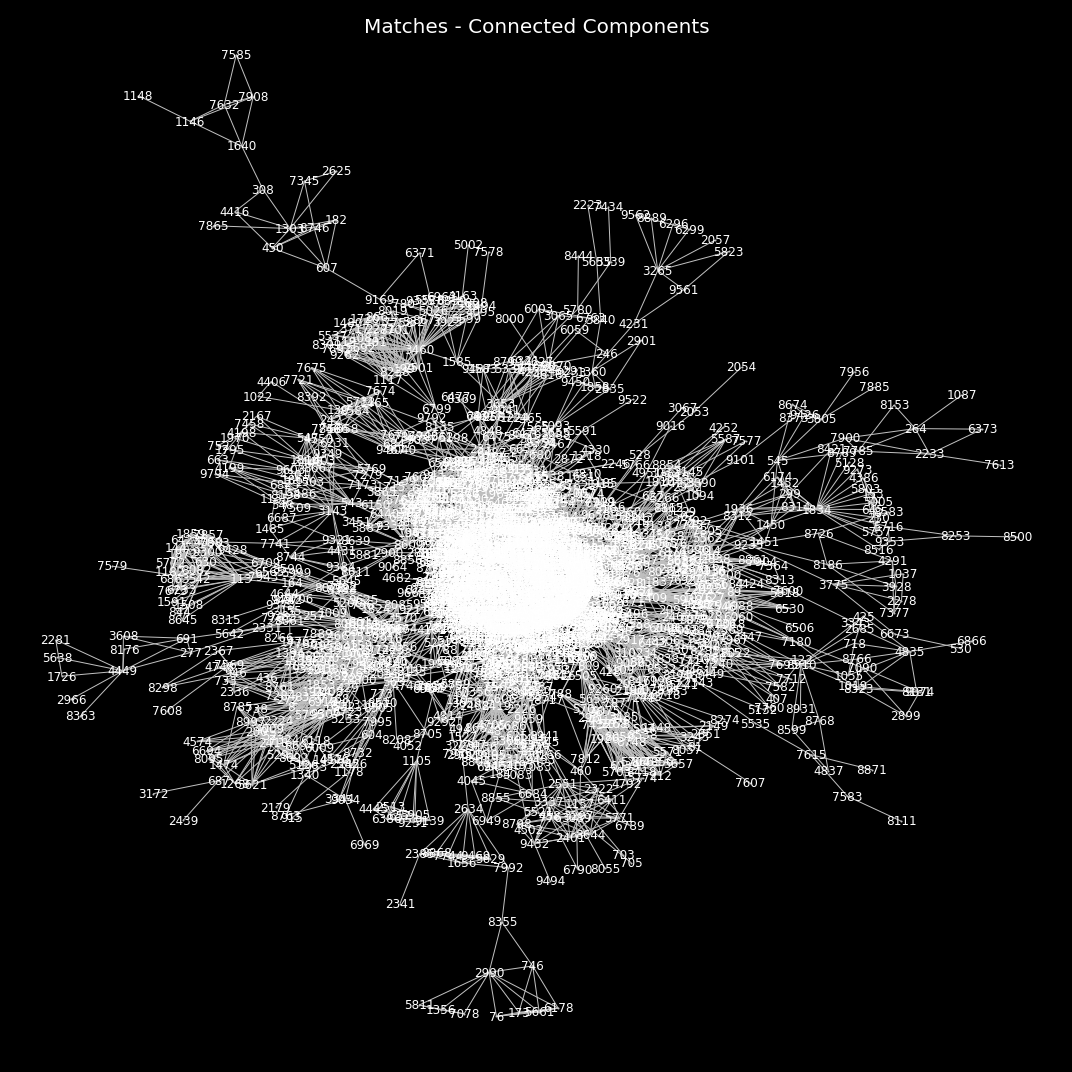

In [43]:
fig = plt.figure(figsize=(15,15), facecolor="black")
ax = nx.draw_networkx(G,
                      with_labels=True,
                      node_size=1,
                      alpha=1,
                      pos=nx.kamada_kawai_layout(G),
#                       pos=nx.spring_layout(G),
                      edge_color="silver",
                      node_color="silver",
                     font_size=12,
                     font_color="white")
plt.axis("off")
plt.tight_layout()
plt.suptitle("Matches - Connected Components", fontsize=20, color="white")
plt.show()

In [44]:
# Print pair of entities

# Examples of not found:
#  ['3460|6963',
#  '1808|4095',
#  '3265|9562',
#  '2551|5771',
#  '6605|7876',
#  '3842|9044',
#  '4208|9532',
#  '9136|9376',
#  '2927|8872',
#  '7867|8584']
print(df.loc[3460]["entityname"])
print(df.loc[6963]["entityname"])

University of Munich
University of Munich, Institute for Computer Science


In [45]:
# Current score for a pair that was not found
testname1 = "University of Oxford"
testname2 = "Oxford University"
fuzz_ratio = fuzz.ratio(testname1, testname2)
fuzz_partial = fuzz.partial_ratio(testname1, testname2)
fuzz_tokensort = fuzz.token_sort_ratio(testname1, testname2)
similarity_score = max(fuzz_ratio, fuzz_partial, fuzz_tokensort)

print(f"fuzz: {fuzz_ratio}, partial: {fuzz_partial}, tokensort: {fuzz_tokensort}, similarity_score: {similarity_score}")

fuzz: 54, partial: 59, tokensort: 92, similarity_score: 92


In [46]:
# Connected component subgraphs
cc_subgraphs = list(nx.connected_components(G))

In [47]:
len(cc_subgraphs)

179

In [48]:
# list(cc_subgraphs[1])

In [49]:
# Generate all matching pairs based on connected components
match_pairs = []
for subgraph in cc_subgraphs:
    cc = list(subgraph)
    cc.sort()
    combos = list(itertools.combinations(cc, 2))
    for c in combos:
        match_pairs.append(c)
#     print(combos)
#     print("-"*72)

In [50]:
len(match_pairs)

309098

In [51]:
match_pairs[:10]

[(2, 7),
 (2, 8),
 (2, 20),
 (2, 26),
 (2, 29),
 (2, 31),
 (2, 34),
 (2, 45),
 (2, 48),
 (2, 52)]

In [52]:
df_ccmatches = pd.DataFrame(match_pairs)
df_ccmatches.columns = ["entityid1", "entityid2"]
df_ccmatches["match_string"] = df_ccmatches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_ccmatches.head()

,entityid1,entityid2,match_string
0,2,7,2|7
1,2,8,2|8
2,2,20,2|20
3,2,26,2|26
4,2,29,2|29


In [53]:
df_ccmatches.shape

(309098, 3)

In [54]:
ccmatches_list = list(df_ccmatches["match_string"])

In [55]:
good_ccmatches = []
for m in ccmatches_list:
    if m in truth_list:
        good_ccmatches.append("Good match")
    else:
        good_ccmatches.append("Bad match")

In [56]:
df_ccmatches["GoodBad"] = good_ccmatches

In [57]:
df_ccmatches.head()

,entityid1,entityid2,match_string,GoodBad
0,2,7,2|7,Bad match
1,2,8,2|8,Bad match
2,2,20,2|20,Bad match
3,2,26,2|26,Bad match
4,2,29,2|29,Bad match


In [58]:
df_ccmatches["GoodBad"].value_counts()

Bad match     295846
Good match     13252
Name: GoodBad, dtype: int64

In [59]:
df_ccmatches.loc[df_ccmatches["GoodBad"]=="Bad match"].sample(5)

,entityid1,entityid2,match_string,GoodBad
78470,807,6174,807|6174,Bad match
294845,2610,6687,2610|6687,Bad match
110241,1365,6860,1365|6860,Bad match
153020,2088,3202,2088|3202,Bad match
18789,130,1109,130|1109,Bad match


In [60]:
found_good_matches = list(df_ccmatches.loc[df_ccmatches["GoodBad"]=="Good match"]["match_string"])

In [61]:
found_good_matches[:10]

['2|9794',
 '7|120',
 '7|515',
 '7|1527',
 '7|2226',
 '7|2419',
 '7|5554',
 '7|5710',
 '7|6166',
 '7|7083']

In [62]:
truth_not_found = []
for t in truth_list:
    if t not in found_good_matches:
        truth_not_found.append(t)
print(f"Number of truths not found: {len(truth_not_found)}")

Number of truths not found: 3156


In [63]:
truth_not_found[:10]

['3469|7230',
 '5403|9385',
 '48|840',
 '146|189',
 '2231|6933',
 '1039|7908',
 '2180|8649',
 '6496|6745',
 '287|2289',
 '8504|8609']

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 75 (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     221405</li>
        <li>Good match     7261</li>
        <li>Good/Bad     0.03</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 80  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     15725</li>
        <li>Good match     4719</li>
        <li>Good/Bad     0.3</li>
    </ul>
</div>


<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 85  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     2253</li>
        <li>Good match     2706</li>
        <li>Good/Bad     1.20</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 88  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     666</li>
        <li>Good match     2127</li>
        <li>Good/Bad     3.19</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     165</li>
        <li>Good match     1339</li>
        <li>Good/Bad     8.12</li>
    </ul>
</div>

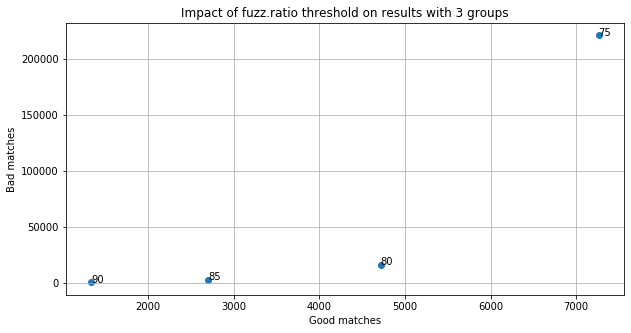

In [64]:
labels=[75,80,85,90]
x=[7261,4719,2706,1339]
y=[221405,15725,2253,165]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x=x, y=y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

# plt.axis("equal")
# plt.xlim(left=0, right=max(y))
plt.title("Impact of fuzz.ratio threshold on results with 3 groups")
plt.xlabel("Good matches")
plt.ylabel("Bad matches")
plt.grid()

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     218</li>
        <li>Good match     1608</li>
        <li>Good/Bad     7.38</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (with stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     227</li>
        <li>Good match     1499</li>
        <li>Good/Bad     6.60</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 75 and average ratio method (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     945037</li>
        <li>Good match     11865</li>
        <li>Good/Bad     0.01</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 20 groups and threshold at 88 and average ratio method (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     1788</li>
        <li>Good match     2889</li>
        <li>Good/Bad     1.62</li>
    </ul>
</div>